<a href="https://colab.research.google.com/github/tashir0605/SentimentSphere/blob/main/Emotion%20Through%20Text/Human_Emotion_through_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Text Emotion Detection

In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
# from sklearn.model_selection import train_test_split,KFold, GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import f1_score
# from sklearn.svm import SVC

#Lime
!pip install lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0cb17a260e7335882be696ed26232f10141e2372dbcb90cac48984c4b528c4fc
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

**Dataset**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
dfs=pd.read_csv("text_emotion_dataset_raw.csv")

In [4]:
assert len(dfs) >= 8000, "Dataset should have at least 8000 rows for test and validation sets."

In [5]:
# Split off df_test and df_val (4000 rows each)
df_temp, df_test = train_test_split(dfs, test_size=4000, random_state=42)
df_train, df_val = train_test_split(df_temp, test_size=4000, random_state=42)

In [6]:
# Verify the sizes
print(f"Training set: {len(df_train)} rows")
print(f"Test set: {len(df_test)} rows")
print(f"Validation set: {len(df_val)} rows")

Training set: 26792 rows
Test set: 4000 rows
Validation set: 4000 rows


In [7]:

# Save the split datasets if needed
df_train.to_csv("df_train.csv", index=False)
df_test.to_csv("df_test.csv", index=False)
df_val.to_csv("df_val.csv", index=False)

In [8]:
df_train.head()

,Emotion,Text
13280,anger,My car won ’ t start ! Stupid old car !
638,joy,Night twitter family! Sleeping in again then m...
29362,joy,"Break! Whatever your challenge, imagine it's o..."
34176,disgust,@peoplemag How dare you make Ryan Gosling the ...
10524,anger,Why not ?


In [9]:
#print the shape of the data set
print(df_train.shape)

(26792, 2)


In [10]:
#print first 5 rows
df_test.head()

,Emotion,Text
28288,sadness,Cody won't be coming anywhere NEAR where I liv...
20066,anger,"Woah, not annoyed much! #JustLikeBefore Some ..."
29377,sadness,"` Forgive me , Miss Kyte , "" said the other la..."
9097,joy,"Great, got a biology ISA this morning"
11127,anger,People don't even know how blessed u can be wh...


In [11]:
#print the shape of the data set
print(df_test.shape)

(4000, 2)


In [12]:
#print first 5 rows
df_val.head()

,Emotion,Text
11277,joy,May and #Bless us all! RT @Ganesha359: @TheB...
30277,anger,"FUCK YOU. Talk to me, not them, they're horrib..."
13462,joy,Pep rally today.
11806,fear,The biggest comes when you focus on the realit...
12566,joy,Come over and visit when you have time .


In [13]:
#print the shape of the data set
print(df_val.shape)

(4000, 2)


In [14]:
#check if the data is balanced or not
df_train.Emotion.value_counts()

,count
Emotion,
joy,8476
sadness,5198
fear,4154
anger,3312
surprise,3177
neutral,1714
disgust,640
shame,121


In [15]:
#check if the data is balanced or not
df_train.Emotion.value_counts() / df_train.shape[0] *100

,count
Emotion,
joy,31.636309
sadness,19.401314
fear,15.504628
anger,12.361899
surprise,11.858017
neutral,6.397432
disgust,2.388773
shame,0.451627


<Axes: xlabel='Emotion', ylabel='count'>

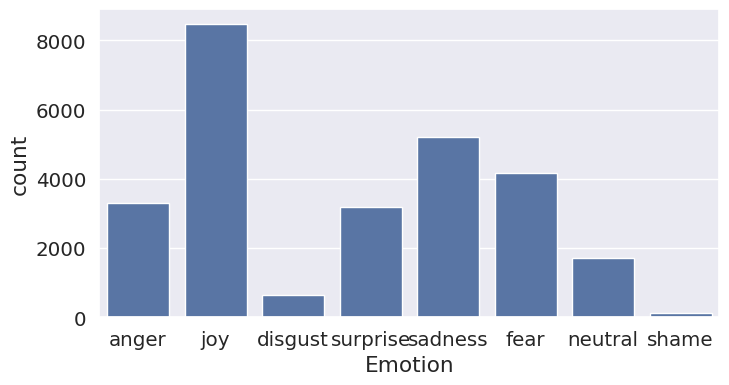

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion',data=df_train)


The provided dataset exhibits class imbalance, with certain emotion categories being more prevalent than others. While there is a possibility to address this imbalance through various techniques, it is noteworthy that the emotions of primary interest are already among the most frequently occurring. Consequently, it is currently deemed acceptable to retain the dataset in its original form, without undertaking explicit measures to rebalance the class distribution.The data is imbalanced so, we may try to balance it but also, the emotions that we interested in are the most repeated emotion so, till now we can keep the data as it is

In [17]:
#print the number of null values in each column
df_train.isnull().sum()

,0
Emotion,0
Text,0


In [18]:
#print the number of duplicated values
df_train.duplicated().sum()

np.int64(2301)

In [19]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [20]:
df_train.shape

(24491, 2)

There is just 2301 row which is duplicated but we need to check also if there are rows having the same text but different emotions

In [21]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Emotion,Text
691,neutral,Why not ?
3316,anger,That's all right . But why were you so rude t...
3381,joy,Certainly .
5943,joy,Thanks .
6587,joy,Yes .
6662,neutral,Bye .
6695,neutral,I'm sorry .
6751,joy,Rescued dogs are often somewhat nervous of peo...
7520,fear,Thank you very much .
7924,neutral,It sure is .


In [22]:
#print some rows to check
df_train[df_train['Text'] == dfs.iloc[18369]['Text']]
df_train[df_train['Text'] == dfs.iloc[10875]['Text']]
df_train[df_train['Text'] == dfs.iloc[24471]['Text']]

,Emotion,Text
14631,joy,“@breannajustus: The Gospel: He is making all ...


In [23]:
# Check which texts have conflicting emotions
conflicting_texts = df_train.groupby("Text")["Emotion"].nunique()
conflicting_texts = conflicting_texts[conflicting_texts > 1]  # Keep only those with more than 1 unique emotion

# Print conflicts
print(df_train[df_train["Text"].isin(conflicting_texts.index)])

# Now, let's keep only the most frequent emotion for each text
df_train = df_train.groupby("Text").agg(lambda x: x.value_counts().idxmax()).reset_index()

# Print new shape after handling duplicates properly
print(df_train.shape)


       Emotion                                               Text
4        anger                                         Why not ? 
315    neutral                                             Yes . 
483    neutral                                              OK . 
691    neutral                                         Why not ? 
767    neutral                                            Sure . 
...        ...                                                ...
22162  neutral               Well , you always say you're busy . 
23472      joy  Just had a great movie marathon with my wonder...
24146  neutral  Could I see the manager please ? I have a comp...
24331  sadness                                        Terrible . 
24471  neutral     And why are you yarning now ? Are you bored ? 

[71 rows x 2 columns]
(24455, 2)


In [24]:
print(df_train["Text"].duplicated().sum())  # Should be 0 if all duplicates were removed


0


In [25]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

,count
stop_words,
4,2903
5,2810
3,2730
6,2476
2,2462
7,2018
0,1907
1,1842
8,1630


The data contains alot of stopwords (some rows contains more than 25 stopword!) so, we need to take care when we remove them as some rows may become empty

<Axes: ylabel='Frequency'>

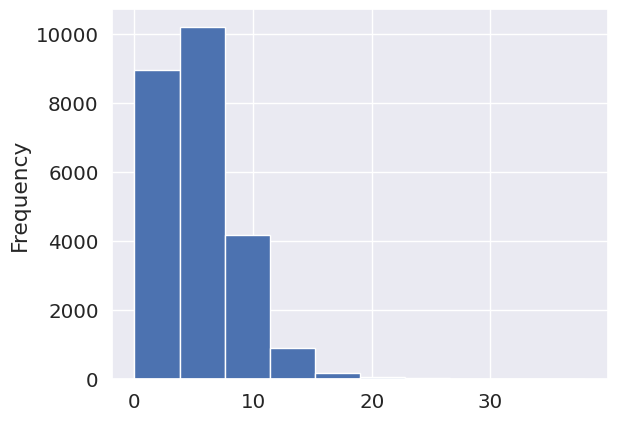

In [26]:

#distribution of stopwords visually
temp['stop_words'].plot(kind= 'hist')

# Test dataset

In [27]:
#check if the data is balanced or not
df_test.Emotion.value_counts()

,count
Emotion,
joy,1278
sadness,740
fear,651
anger,498
surprise,410
neutral,286
disgust,120
shame,17


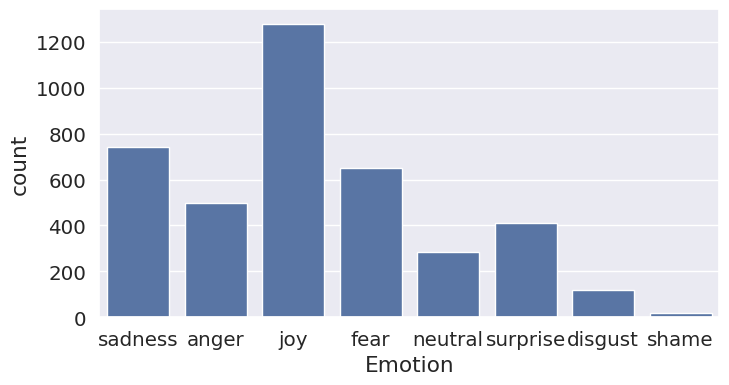

In [28]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test);

In [29]:
#print the number of null values in each column
df_test.isnull().sum()

,0
Emotion,0
Text,0


In [30]:
#print the number of duplicated values
df_test.duplicated().sum()

np.int64(116)

In [31]:
#print the rows which are duplicated
df_test[df_test['Text'].duplicated() == True]

,Emotion,Text
27478,neutral,What ?
20736,joy,Thank you .
7306,fear,"“@RevRunWisdom: not afraid of tomorrow, for I ..."
14540,neutral,Thank you .
31747,sadness,I remember my despondency in 1926 when Abd al ...
...,...,...
6857,neutral,When ?
12471,joy,From a starving stray it was transformed into ...
19897,fear,I get lightheaded whenever they show surgical ...
5824,neutral,Yes .


In [32]:
#removing duplicated values
index = df_test[df_test.duplicated() == True].index
df_test.drop(index, axis = 0, inplace = True)
df_test.reset_index(inplace=True, drop = True)

In [34]:
df_test.shape

(3884, 2)

In [33]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_test[df_test['Text'].duplicated() == True]

,Emotion,Text
499,neutral,Thank you .
729,anger,See you .
2109,joy,All right .
3157,neutral,Okay .


In [36]:
#print some rows to check
df_test[df_test['Text'] == dfs.iloc[419]['Text']]
df_test[df_test['Text'] == dfs.iloc[729]['Text']]
df_test[df_test['Text'] == dfs.iloc[2109]['Text']]

,Emotion,Text
142,neutral,What for ?


In [37]:
# Check which texts have conflicting emotions
conflicting_texts = df_test.groupby("Text")["Emotion"].nunique()
conflicting_texts = conflicting_texts[conflicting_texts > 1]  # Keep only those with more than 1 unique emotion

# Print conflicts
print(df_test[df_test["Text"].isin(conflicting_texts.index)])

# Now, let's keep only the most frequent emotion for each text
df_test = df_test.groupby("Text").agg(lambda x: x.value_counts().idxmax()).reset_index()

# Print new shape after handling duplicates properly
print(df_test.shape)

      Emotion           Text
225       joy   Thank you . 
499   neutral   Thank you . 
508   neutral     See you . 
515       joy        Okay . 
729     anger     See you . 
923   neutral   All right . 
2109      joy   All right . 
3157  neutral        Okay . 
(3880, 2)


In [38]:
print(df_train["Text"].duplicated().sum())  # Should be 0 if all duplicates were removed

0


In [39]:
#Count the number of stopwords in the data
temp =df_test.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

,count
stop_words,
4,490
3,451
5,423
2,413
6,342
7,309
0,303
1,296
8,265


<Axes: ylabel='Frequency'>

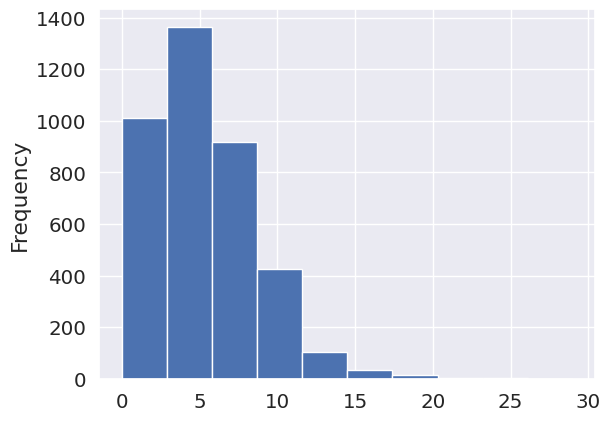

In [40]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

# Validation Dataset

In [41]:
#check if the data is balanced or not
df_val.Emotion.value_counts()

,count
Emotion,
joy,1291
sadness,784
fear,605
anger,487
surprise,475
neutral,254
disgust,96
shame,8


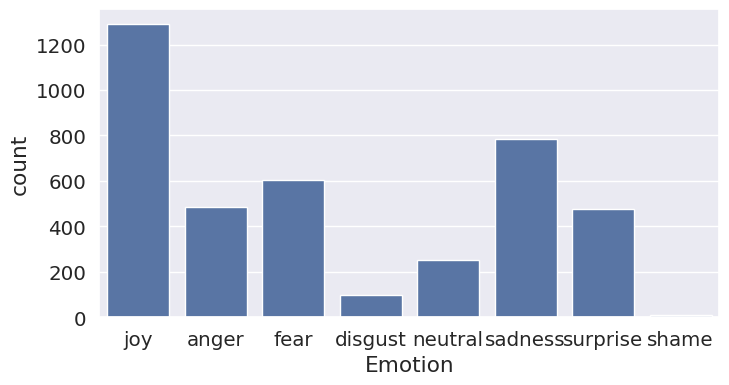

In [42]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_val);

In [43]:
#print the number of null values in each column
df_val.isnull().sum()

,0
Emotion,0
Text,0


In [44]:
#print the number of duplicated values
df_val.duplicated().sum()

np.int64(107)

In [45]:
#print the rows which are duplicated
df_val[df_val['Text'].duplicated() == True]

,Emotion,Text
6793,anger,Germans were resentful of France 's post-war a...
6986,joy,Love is the highest vibration in the Universe....
16024,anger,Jack was mad and even madder with the American...
10906,anger,Having already paid for my return ticket I was...
29938,fear,If you are really nervous of being out and abo...
...,...,...
13371,fear,"Then we killed her , and I felt frightened of ..."
28038,neutral,I hope so .
5148,fear,"“@RevRunWisdom: not afraid of tomorrow, for I ..."
33919,joy,You 're pleased about his engagement -- he tol...


In [46]:
#removing duplicated values
index = df_val[df_val.duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [47]:
df_val.shape

(3893, 2)

In [48]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_val[df_val['Text'].duplicated() == True]

,Emotion,Text
1082,joy,OK .
2563,joy,Thanks .
3371,joy,Thank you .


In [49]:
# Check which texts have conflicting emotions
conflicting_texts = df_val.groupby("Text")["Emotion"].nunique()
conflicting_texts = conflicting_texts[conflicting_texts > 1]  # Keep only those with more than 1 unique emotion

# Print conflicts
print(df_val[df_val["Text"].isin(conflicting_texts.index)])

# Now, let's keep only the most frequent emotion for each text
df_val = df_val.groupby("Text").agg(lambda x: x.value_counts().idxmax()).reset_index()

# Print new shape after handling duplicates properly
print(df_val.shape)

      Emotion           Text
165   neutral   Thank you . 
230   neutral          OK . 
1082      joy          OK . 
1092  neutral      Thanks . 
2563      joy      Thanks . 
3371      joy   Thank you . 
(3890, 2)


In [50]:
print(df_val["Text"].duplicated().sum())  # Should be 0 if all duplicates were removed

0


In [51]:
#Count the number of stopwords in the data
temp =df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]

,count
stop_words,
4,468
5,459
2,413
6,396
3,395
7,337
1,319
0,302
8,236


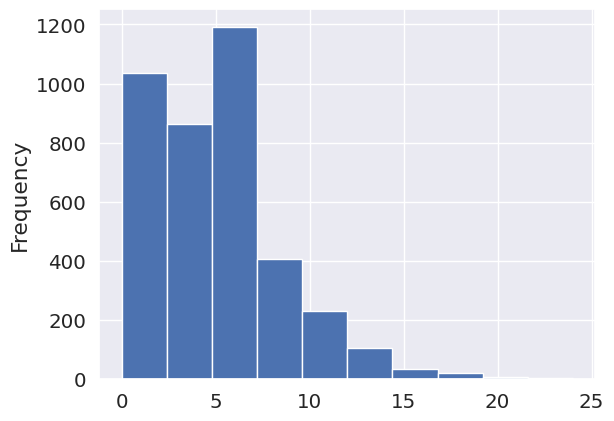

In [52]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist');

# Compare rows of the datasets

Check that there is no data leakage

In [53]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""

    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )

    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]

    # Return the filtered DataFrame
    return diff_df

In [54]:
dataframe_difference(df_train, df_test, which='both')
dataframe_difference(df_train, df_val, which='both')
dataframe_difference(df_val, df_test, which='both')

,Text,Emotion,_merge
0,Infiltration in our lives. The illusion of ...,fear,both
24,About what ?,neutral,both
30,All right .,neutral,both
34,And ?,neutral,both
80,Certainly .,neutral,both
...,...,...,...
6987,"` You could have lent it to me , "" Paula said ...",anger,both
7364,"not afraid of tomorrow, for I have seen yester...",fear,both
7614,"«@RevRunWisdom not afraid of tomorrow, for I h...",fear,both
7633,"“@RevRunWisdom not afraid of tomorrow, for I h...",fear,both


# Cleaning

In [55]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [56]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]

    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):

    text = text.split()

    text=[y.lower() for y in text]

    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [57]:
normalized_sentence("My Name is _Maysaa. @Tweets,  ")

'name maysaa tweet'

In [58]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

# Modeling

TF-IDF (Term Frequency - Inverse Document Frequency) is a technique used to address certain issues associated with word counts. In traditional word counts, the most frequently occurring words, including common stop words, are given significant attention despite their lack of importance.

TF-IDF adjusts these word counts by considering two factors:

1. Term Frequency (TF): This measures the frequency of a term within a specific document. It assigns higher weight to words that appear more frequently in the document.

2. Inverse Document Frequency (IDF): This measures the rarity of a term across all documents in a corpus. It assigns higher weight to words that are relatively rare across the entire collection of documents.

By combining TF and IDF, TF-IDF aims to give more importance to words that are both rare across all documents (high IDF) and appear frequently within a specific document (high TF). This approach helps highlight terms that are distinctive to a particular document.

In TF-IDF, if a word appears only in the current document or sentence, it will have a TF-IDF value of 1. If a word appears in all documents or sentences except the current one, it will have a TF-IDF value of 0. For words that are common across both the current document and all others, their TF (count) will be high, but the IDF (discount) will be even higher, resulting in a lower overall TF-IDF value.

This way, TF-IDF offers a more nuanced representation of word importance by considering both the local importance within a document (TF) and the global rarity across all documents (IDF).

**Data pre-processing**

In Natural Language Processing (NLP), **neattext** refers to a Python library designed to provides a set of simple and easy-to-use functions for cleaning, formatting, and processing text data.

**Some of the common functionalities offered by the neattext library include:**

1. Removing special characters and unwanted symbols

2. Normalization: This includes tasks like converting text to lowercase, expanding contractions (e.g., changing "I'm" to "I am"), and removing stopwords (common words like "the", "is", etc. that don’t add much meaning in NLP tasks).

3. Handling tokenization: neattext can tokenize a given sentence into words, which is useful for many downstream NLP tasks.

4. Text formatting: It provides tools for removing extra whitespaces, line breaks, and formatting issues.

In [59]:
#Preprocess text
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [60]:
def train_model(model, data, targets):

    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [61]:
def get_F1(trained_model,X,y):

    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

# Better

**Text Preprocessing**

In [62]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [64]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [65]:
#print the labels after encoding
print(set(y_train))

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)}


In [66]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

**Tokenization**

In [67]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))#

In [68]:
#document count: A dictionary of words and how many documents each appeared in.
#in this dataset the output will be the number of rows
tokenizer.document_count

28335

In [72]:
#print the index of a single word
tokenizer.word_index['towards']

748

In [73]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[0].split())

[[1611], [9], [44], [56], [12542], [12543], [151]]

In [74]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
#the sentence contains three words and the size of the vocabulary is 31649
tokenizer.texts_to_matrix(X_train[0].split()).shape

(7, 31649)

In [78]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

# Padding


The vectors we obtain are generally not of equal lengths


For that, we might need to pad the sequences to max len.

In [79]:
df_test.shape

(3880, 2)

In [80]:
maxlen = max([len(t) for t in df_train['Text']])
maxlen

631

In [81]:
X_train = pad_sequences(sequences_train, maxlen=631, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=631, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=631, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 31649


In [82]:
#before
sequences_train[0]

[1611, 9, 44, 56, 12542, 12543, 151]

In [83]:
#after
X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [84]:
print(y_train)

[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


# Word Embedding

This code defines the following variables:

path_to_glove_file: The file path to the GloVe word vectors file.

num_tokens: The size of the vocabulary. This is typically the number of unique words in the dataset.

embedding_dim: The dimensionality of the word vectors. This is usually set to a fixed value (e.g., 200, 300, etc.) depending on the size of the word vectors file that is being used.

hits: A counter for the number of words that are found in the embeddings_index dictionary.

misses: A counter for the number of words that are not found in the embeddings_index dictionary.

embeddings_index: A dictionary that will store the word vectors, with the words as keys and the word vectors as values.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove/


--2025-03-15 16:44:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-15 16:44:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-15 16:44:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
path_to_glove_file = "glove/glove.6B.200d.txt"


In [ ]:

num_tokens = vocabSize
embedding_dim = 200 #latent factors or features
hits = 0
misses = 0
embeddings_index = {}

In this code snippet, an embedding matrix is initialized with all zero values. The aim is to assign word vectors to the corresponding rows of the embedding matrix using a loop through the vocabulary defined by the tokenizer object.


The embedding matrix has a size of num_tokens rows and embedding_dim columns. The num_tokens represents the size of the vocabulary, and embedding_dim refers to the dimensionality of the word vectors.


For each word in the vocabulary, the code checks if it exists in the embeddings_index dictionary. If the word is found, its corresponding word vector is retrieved from the embeddings_index dictionary and assigned to the respective row in the embedding matrix. On the other hand, if the word is not found in the embeddings_index dictionary, the row in the embedding matrix remains all zeros.


During this process, two counters are maintained: hits and misses. The hits counter is incremented every time a word is successfully assigned a word vector from the embeddings_index dictionary. Conversely, the misses counter is incremented when a word is not found in the embeddings_index dictionary.


Finally, the code prints out the number of words that were successfully converted (hits) and the number of words that were not found in the embeddings_index dictionary (misses). This provides insights into the coverage of word vectors in the embeddings_index dictionary for the given vocabulary.

In [ ]:
# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 20324 words (11324 misses)


# Modeling¶


**The model consists of several layers:**

An Embedding layer that takes in integer-encoded text and looks up the embedding vector for each word in the input. The input length is set to the length of the input sequences, and the weights are initialized with an embedding matrix that has been pre-trained on a large dataset. The embedding layer is not trainable, meaning that the weights of this layer will not be updated during training.

Three Bidirectional layers, each of which applies a forward and backward LSTM to the input. LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. The dropout and recurrent dropout arguments specify the dropout rate to apply to the inputs and recurrent inputs of the LSTMs, respectively. The return_sequences argument specifies whether the LSTM should return the full sequences of outputs or just the last output of each sequence.

A Dense layer that applies a linear transformation to the input to produce the output. The output has 6 units and uses the 'softmax' activation function, which means that it will output a probability distribution over the 6 classes.

In [85]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

NameError: name 'embedding_matrix' is not defined

In [ ]:
!pip install neattext


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 5.7 MB/s eta 0:00:00


In [ ]:
import neattext.functions as nfx

**User handles** in this case are references to social media usernames, which typically begin with an "@" symbol (e.g., @username).

In [ ]:
df['Clean_Text']=df['Text'].apply(nfx.remove_userhandles)

In [ ]:
df

,Emotion,Text,Clean_Text
0,neutral,,
1,joy,sage act upgrade list tommorow,sage act upgrade list tommorow
2,sadness,way homegirl baby funeral man hate funeral rea...,way homegirl baby funeral man hate funeral rea...
3,joy,eye true hazel eye and brilliant regular featu...,eye true hazel eye and brilliant regular featu...
4,joy,iluvmiasantos ugh babe hugggzzz u babe naamaze...,iluvmiasantos ugh babe hugggzzz u babe naamaze...
...,...,...,...
34787,surprise,michelgw gift hope like it hand made wear keep...,michelgw gift hope like it hand made wear keep...
34788,joy,world didnt give me so world definitely cnt ta...,world didnt give me so world definitely cnt ta...
34789,anger,man robbed today,man robbed today
34790,fear,youu call jealousy call losing you,youu call jealousy call losing you


Code to see the Functions under neattext

In [ ]:
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [ ]:
# Remove the Stopwords
df['Clean_Text']=df['Clean_Text'].apply(nfx.remove_stopwords)

In [ ]:
df

,Emotion,Text,Clean_Text
0,neutral,,
1,joy,sage act upgrade list tommorow,sage act upgrade list tommorow
2,sadness,way homegirl baby funeral man hate funeral rea...,way homegirl baby funeral man hate funeral ble...
3,joy,eye true hazel eye and brilliant regular featu...,eye true hazel eye brilliant regular feature o...
4,joy,iluvmiasantos ugh babe hugggzzz u babe naamaze...,iluvmiasantos ugh babe hugggzzz u babe naamaze...
...,...,...,...
34787,surprise,michelgw gift hope like it hand made wear keep...,michelgw gift hope like hand wear warm lol
34788,joy,world didnt give me so world definitely cnt ta...,world didnt world definitely cnt away
34789,anger,man robbed today,man robbed today
34790,fear,youu call jealousy call losing you,youu jealousy losing


**Splitting data into input variables and target variable**

**x**: Features are the attributes and variables extracted from the dataset. These extracted features are used as inputs to the model during training.

**y**: Labels are the output or the target variable.

In [ ]:
x=df['Clean_Text']
y=df['Emotion']

**Splitting data into train and test set**

We need to split our dataset into a train set and test set. The model will learn from the train set. We will use the test set to evaluate the model performance and measure the model’s knowledge capability.

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

**Training the Model**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])
pipe_lr.fit(x_train,y_train)
pipe_lr.score(x_test,y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6270358306188925

In [ ]:
pipe_svm = Pipeline(steps=[('cv',CountVectorizer()),('svc', SVC(kernel = 'rbf', C = 10))])
pipe_svm.fit(x_train,y_train)
pipe_svm.score(x_test,y_test)

In [ ]:
pipe_rf = Pipeline(steps=[('cv',CountVectorizer()),('rf', RandomForestClassifier(n_estimators=10))])
pipe_rf.fit(x_train,y_train)
pipe_rf.score(x_test,y_test)

In [ ]:
import joblib
pipeline_file = open("text_emotion.pkl","wb")
joblib.dump(pipe_lr,pipeline_file)
pipeline_file.close()